In [32]:
import os
import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import is_numeric_dtype

from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [33]:
sns.set_theme(style="whitegrid")

#### Carregamento dos dados

In [34]:
try:
    BASEDIR = os.path.abspath(os.path.dirname(__file__))
except NameError:
    BASEDIR = os.getcwd()

DBPATH = os.path.join(BASEDIR, "db.sqlite3")

In [35]:
# criando engine para conexao com o sqlite
engine = create_engine("sqlite:///" + DBPATH)

In [36]:
with engine.connect() as con:
    df = pd.read_sql_table("customer", con=con)

In [37]:
df.head()

,id,age,usage,plan,customer_satisfaction,time_contract,monthly_value,churn
0,1,56,52,Premium,1,Curto,75.48,0
1,2,69,65,Basico,4,Curto,79.25,0
2,3,46,76,Standard,3,Longo,183.56,0
3,4,32,42,Basico,2,Longo,162.50,0
4,5,60,74,Standard,2,Longo,186.23,1


In [38]:
df.drop("id", axis=1, inplace=True)
df.shape

(1000, 7)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    1000 non-null   int64  
 1   usage                  1000 non-null   object 
 2   plan                   1000 non-null   object 
 3   customer_satisfaction  1000 non-null   int64  
 4   time_contract          1000 non-null   object 
 5   monthly_value          1000 non-null   float64
 6   churn                  1000 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB


In [40]:
df["usage"] = df["usage"].astype(np.int16)

#### Análise Exploratoria

In [41]:
df.isna().sum()

age                      0
usage                    0
plan                     0
customer_satisfaction    0
time_contract            0
monthly_value            0
churn                    0
dtype: int64

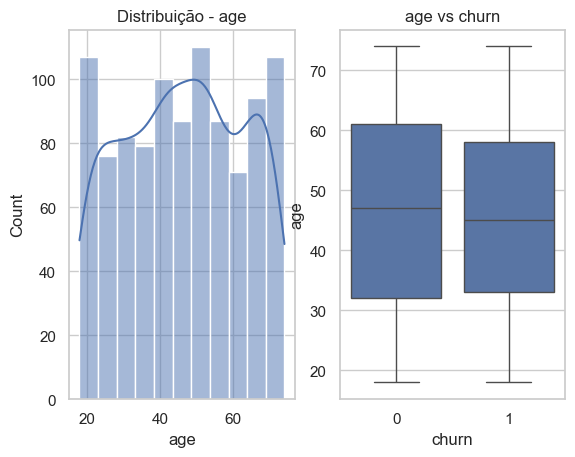

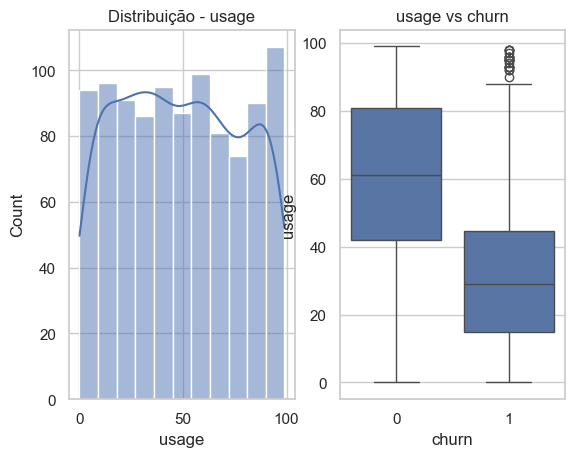

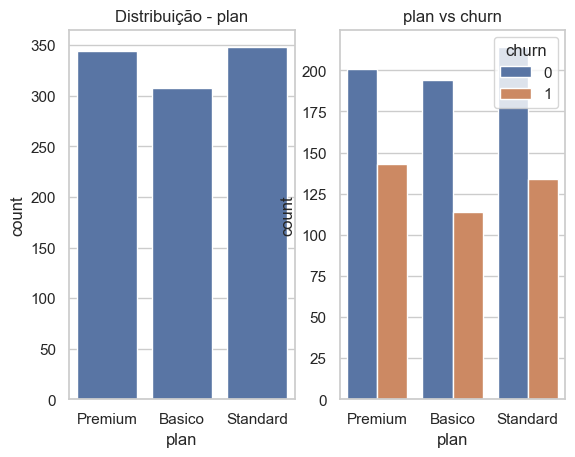

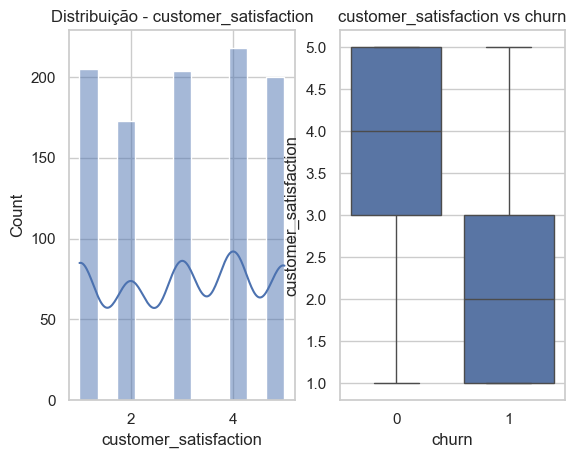

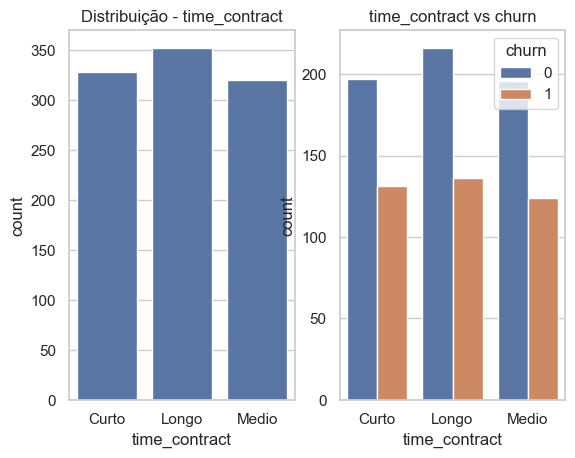

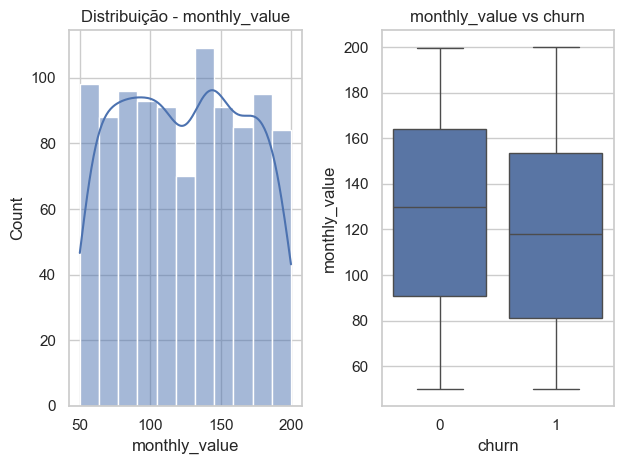

In [42]:
for column in df.columns:
    if column != "churn":
        fig, axes = plt.subplots(1, 2)
        if is_numeric_dtype(df[column].dtype):
            sns.histplot(df[column], kde=True, ax=axes[0])
            sns.boxplot(x="churn", y=column, data=df, ax=axes[1])
        else:
            sns.countplot(x=column, data=df, ax=axes[0])
            sns.countplot(x=column, hue="churn", data=df, ax=axes[1])

        axes[0].set_title(f"Distribuição - {column}")
        axes[1].set_title(f"{column} vs churn")
plt.tight_layout()
plt.show()

#### Divisão de dados em treino e teste

In [43]:
X = df.drop("churn", axis=1)
y = df["churn"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [45]:
y_train.value_counts()

churn
0    486
1    314
Name: count, dtype: int64

In [46]:
y_test.value_counts()

churn
0    123
1     77
Name: count, dtype: int64

#### Pré-processamento

In [47]:
categorical = df.select_dtypes(include=["object"]).columns
categorical

Index(['plan', 'time_contract'], dtype='object')

In [48]:
# OHE
ohe = OneHotEncoder(sparse_output=False)

In [49]:
X_train_encoded = pd.DataFrame(ohe.fit_transform(X_train[categorical]))
X_test_encoded = pd.DataFrame(ohe.transform(X_test[categorical]))

# renomeando as colunas
X_train_encoded.columns = ohe.get_feature_names_out(categorical)
X_test_encoded.columns = ohe.get_feature_names_out(categorical)

# dropando as colunas categorias
X_train_preprocessed = X_train.drop(categorical, axis=1).reset_index(drop=True)
X_test_preprocessed = X_test.drop(categorical, axis=1).reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [50]:
X_train_processed = pd.concat([X_train_preprocessed, X_train_encoded], axis=1)
X_test_processed = pd.concat([X_test_preprocessed, X_test_encoded], axis=1)

In [51]:
X_train_processed.head(10)

,age,usage,customer_satisfaction,monthly_value,plan_Basico,plan_Premium,plan_Standard,time_contract_Curto,time_contract_Longo,time_contract_Medio
0,39,91,3,90.79,0.0,1.0,0.0,1.0,0.0,0.0
1,18,80,3,151.37,1.0,0.0,0.0,0.0,1.0,0.0
2,58,81,5,73.45,1.0,0.0,0.0,0.0,0.0,1.0
3,68,74,4,110.48,1.0,0.0,0.0,1.0,0.0,0.0
4,55,28,1,97.24,0.0,1.0,0.0,0.0,0.0,1.0
5,62,52,2,153.21,0.0,1.0,0.0,0.0,0.0,1.0
6,59,67,4,182.91,0.0,1.0,0.0,0.0,0.0,1.0
7,27,1,3,106.68,1.0,0.0,0.0,0.0,1.0,0.0
8,71,84,3,122.32,1.0,0.0,0.0,0.0,0.0,1.0
9,71,31,1,131.04,0.0,0.0,1.0,0.0,0.0,1.0


In [52]:
scaler = StandardScaler()

# customer_satisfaction ja está em ordinal
# uso também está em uma escala aceitavel


numerics = ["age"]


X_train_processed[numerics] = scaler.fit_transform(
    scaler.fit_transform(X_train_processed[numerics])
)


X_test_processed[numerics] = scaler.transform(
    scaler.transform(X_test_processed[numerics])
)

#### Modelo

In [53]:
X_train_processed.rename(str, axis=1, inplace=True)
X_test_processed.rename(str, axis=1, inplace=True)

In [54]:
model_rf_1 = RandomForestClassifier(random_state=42)

model_rf_1.fit(X_train_processed, y_train)

predict = model_rf_1.predict(X_test_processed)

print("Accuracy: ", accuracy_score(y_test, predict))
print(classification_report(y_test, predict))

Accuracy:  0.77
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       123
           1       0.72      0.66      0.69        77

    accuracy                           0.77       200
   macro avg       0.76      0.75      0.75       200
weighted avg       0.77      0.77      0.77       200



In [55]:
model_lgb_1 = LGBMClassifier(random_state=42, verbose=-1)

model_lgb_1.fit(X_train_processed, y_train)

predict_lgb = model_lgb_1.predict(X_test_processed)

print("Accuracy: ", accuracy_score(y_test, predict_lgb))
print(classification_report(y_test, predict_lgb))

Accuracy:  0.825
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       123
           1       0.80      0.73      0.76        77

    accuracy                           0.82       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.82      0.82       200



In [56]:
model_xbost_1 = XGBClassifier(random_state=42)

model_xbost_1.fit(X_train_processed, y_train)

predict_xbost = model_xbost_1.predict(X_test_processed)

print("Accuracy: ", accuracy_score(y_test, predict_xbost))
print(classification_report(y_test, predict_xbost))

Accuracy:  0.81
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       123
           1       0.77      0.71      0.74        77

    accuracy                           0.81       200
   macro avg       0.80      0.79      0.80       200
weighted avg       0.81      0.81      0.81       200



#### Validação cruzada

In [57]:
model_rf_1_cv = RandomForestClassifier(random_state=42)
rd1_cv_scores = cross_val_score(
    model_rf_1_cv, X_train_processed, y_train, cv=5)
rd1_cv_scores

array([0.775  , 0.78125, 0.75625, 0.7125 , 0.725  ])

In [58]:
model_lgb_1_cv = LGBMClassifier(random_state=42, verbose=-1)
lgb1_cv_scores = cross_val_score(
    model_lgb_1_cv, X_train_processed, y_train, cv=5)
lgb1_cv_scores

array([0.79375, 0.7375 , 0.7875 , 0.75625, 0.70625])

In [59]:
model_xbost_1_cv = XGBClassifier(random_state=42)
xbost1_cv_scores = cross_val_score(
    model_xbost_1_cv, X_train_processed, y_train, cv=5)
xbost1_cv_scores

array([0.78125, 0.7125 , 0.75   , 0.73125, 0.70625])

#### Otimiação de hiperparametros

In [60]:
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 3, 6, 9],
    "min_samples_leaf": [1, 3, 5],
}

model_rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    model_rf, param_grid=params, cv=5, scoring="accuracy", n_jobs=-1
)

grid_rf.fit(X_train_processed, y_train)

best_params = grid_rf.best_params_
best_score = grid_rf.best_score_
print(best_params)
print(best_score)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
0.7687499999999999


In [61]:
params = {
    "n_estimators": [50, 55, 60, 65],
    "max_depth": [None, 10, 13, 16, 20],
    "min_samples_split": [2, 3, 6, 9],
    "learning_rate": [0.1, 0.05, 0.07, 0.9, 1],
    "min_child_samples": [1, 15, 20, 25, 30],
}

model_lgbm = LGBMClassifier(random_state=42, verbose=-1)

grid_lgbm = GridSearchCV(
    model_lgbm, param_grid=params, cv=5, scoring="accuracy", n_jobs=-1
)

grid_lgbm.fit(X_train_processed, y_train)

best_params = grid_lgbm.best_params_
best_score = grid_lgbm.best_score_
print(best_params)
print(best_score)

{'learning_rate': 0.07, 'max_depth': 13, 'min_child_samples': 20, 'min_samples_split': 2, 'n_estimators': 55}
0.78125


In [62]:
params = {
    "n_estimators": [50, 55, 60, 65],
    "max_depth": [None, 10, 13, 16, 20],
    "learning_rate": [0.1, 0.05, 0.07, 0.9, 1],
    "min_child_weight": [1, 2, 3, 4],
}

model_xgbt = XGBClassifier()

grid_xgbt = GridSearchCV(
    model_xgbt, param_grid=params, cv=5, scoring="accuracy", n_jobs=-1
)

grid_xgbt.fit(X_train_processed, y_train)

best_params = grid_xgbt.best_params_
best_score = grid_xgbt.best_score_
print(best_params)
print(best_score)

{'learning_rate': 0.1, 'max_depth': None, 'min_child_weight': 3, 'n_estimators': 55}
0.77375
